# Second COMP421 Assignment

Suggestion: just edit and add cells to this, and submit a notebook? Give it a name that _starts with your name_, such as Frean_SecondAssignment.ipynb

Please submit using the usual ECS [submission system](https://apps.ecs.vuw.ac.nz/submit/COMP421).

### What this is about
"Autoencoders" are neural networks which attempt to reproduce their input at their output, after having passed the information through some form of bottleneck, such as a hidden layer having fewer units than the input. They are trained in the usual way (in this case, by doing gradient descent on the sum of squared errors), so in a sense they're just regular backprop networks. What makes them interesting is the _encoding_ of the inputs that results. The mapping from input to the bottleneck layer can be thought of as an "encoder" and, from there to the output as a "decoder". To the extent that the network succeeds in reproducing the input, it has captured the essential structure in the encoding, ie. the hidden layer activations.

So when you learn an autoencoder, using the classic supervised learning algorithm of backpropagation, you're really doing a form of _unsupervised_ learning: in the learning process the network is "discovering" a compact encoding of the dataset.

### PREP: get comfortable with autograd
 
autograd is probably the best thing since sliced bread. You write some function, then autograd will give you a function that takes the gradient of it. Here is an example: [autograd on sin function](https://github.com/garibaldu/comp421/blob/master/notebooks/autograd_example.ipynb). For part B here you will write your own neural network's forward pass and loss function, and use autograd to find the gradient for use in Stochastic Gradient Descent. 

(No more messing about with awkward buggy gradient calculations! No more tearing that loaf apart with your bare hands!)

### A: Principal Components Analysis

Find the first few Principal Components of the sklearn digits data (ie. the data from  the [kNN example](https://github.com/garibaldu/comp421/blob/master/notebooks/knn_on_little_digits.ipynb)), and show them as images. It doesn't really matter how you do this - perhaps sklearn itself can do it for you?

In [1]:
import autograd.numpy as np
import sklearn.datasets as ds
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
digits = ds.load_digits()
X = digits.data
print(X.shape)

(1797, 64)


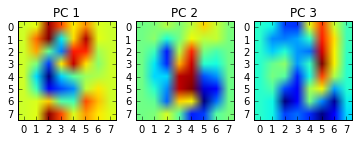

In [3]:
desired_num_components = 3

# Calculate the non-normalised principal components of the digits
# data.
pca = PCA(n_components=desired_num_components)
pca.fit(X)

fig = plt.figure()
for i in range(desired_num_components):
    fig.add_subplot(1, desired_num_components, i + 1)
    plt.imshow(np.reshape(pca.components_[i], (8, 8)))
    plt.title("PC " + str(i))

### B: autoencoding with linear hidden layer
   1. use autograd to learn a neural network that is entirely linear, with inputs _and outputs_ being the sklearn digits, and a single hidden unit. Show the input and output weights: are they the same as the first principal component?
   1. now freeze that unit's weights (both in and out) and learn a second hidden unit.  Show the input and output weights: are they the same as the second principal component?
   1. now train the whole thing at once, instead of unit-by-unit. Are the results different?
   1. account for what you see.

In [9]:
import os
from autograd import grad
from autograd.util import flatten_func
from six.moves import cPickle as pickle

In [6]:
batch_size = 4
num_epochs = 1000
step_size = 0.001

num_batches = int(np.ceil(X.shape[0] / batch_size))

In [38]:
def init_weights(architecture):
    """Returns a list of weights for each layer
    in the neural network.
    """
    return [(np.random.randn(m, n),
             np.random.randn(n)) 
            for m, n in zip(architecture[:-1], architecture[1:])]

def batch_indices(iter):
    """Returns a slice indicating which training examples to
    use during the specified iteration.
    """
    idx = iter % num_batches
    return slice(idx * batch_size, (idx + 1) * batch_size)

def neural_net_predict(params, inputs, nonlin=None):
    """Performs a forward pass through a neural network. 
    
    If the nonlin param is set, then the weighted sum are 
    transformed into activations using the specified
    activation function.
    """
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = nonlin(outputs) if nonlin else outputs
            
    return outputs

def sse(predicted, target):
    """The sum of squared errors between the predicted values
    and targets.
    """
    return np.sum((target - predicted)**2)

def objective(params, iter):
    idx = batch_indices(iter)
    inputs = X[idx]
    predicted = neural_net_predict(params, inputs)
    # Since we're training an autoencoder, the targets are 
    # equal to the inputs.
    return sse(predicted, target=inputs)

grad_objective = grad(objective)

def adam(grad, init_params, callback=None, num_iters=100,
         step_size=0.001, b1=0.9, b2=0.999, eps=10**-8, unfrozen=None):
    """Adam as described in http://arxiv.org/pdf/1412.6980.pdf.
    
    Note that (rather confusingly), when unfrozen=None, all parameters are
    treated as unfrozen (i.e. all parameters are updated / learnt).
    """
    flattened_grad, unflatten, x = flatten_func(grad, init_params)
    
    m = np.zeros(len(x))
    v = np.zeros(len(x))
    for i in range(num_iters):
        g = flattened_grad(x, i)
        if callback: callback(i)
        m = (1 - b1) * g      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        # Only update the unfrozen weights.
        x[unfrozen] = x[unfrozen] - step_size*mhat[unfrozen]/(np.sqrt(vhat[unfrozen]) + eps)
    return unflatten(x)

Some utility functions...

In [79]:
def print_progress(iter):
    if iter % num_batches == 0:
        workdone = iter / (num_epochs * num_batches)
        print("\rTraining: [{0:50s}] {1:.1f}%".format('#' * int(workdone * 50), workdone*100), end="", flush=True)
        
def display_weights(params, hidden_unit, goal_weights):
    """Plots the weights in params that connect to the specified
    hidden_unit against the goal_weights (goal_weights in this
    specific context will be one of the initial principal components.)
    """
    num_figs = len(params) + 1
    
    fig = plt.figure()

    fig.add_subplot(1, num_figs, 1)
    plt.imshow(np.reshape(goal_weights, (8, 8)))
    plt.title("Goal weights")
    
    for i in range(num_params):
        fig.add_subplot(1, num_figs, i + 2)
        layer_weights = (params[i])[0]
        if i == 0:
            plt.imshow(np.reshape(layer_weights[:,hidden_unit], (8, 8)))
        else:
            plt.imshow(np.reshape(layer_weights[hidden_unit,:], (8, 8)))
        plt.title("l%s weights" % str(i))

# Let's visualise some of the predictions of the autoencoder.
def visualise_predictions(params, data, num_predictions=5):
    """Displays the target value and what the neural net predicts
    for certain input examples.
    """
    for i in range(num_predictions):
        instance = np.random.randint(0, X.shape[0])
        test_predict = neural_net_predict(params, data[instance])
        
        fig = plt.figure()
        fig.add_subplot(1, 2, 1)
        plt.imshow(np.reshape(data[instance], (8, 8)), cmap="gray")
        plt.title("Target")
        fig.add_subplot(1, 2, 2)
        plt.imshow(np.reshape(test_predict, (8, 8)), cmap="gray")
        plt.title("neural_net_predict")

def pickle_params(fname, params, force=False):
    """Writes optimised weights / biases to memory, so we can use
    them later on without having to retrain the model.
    """
    fname = fname + ".pickle"
    
    if os.path.exists(fname) and not force:
        print("%s already present - Skipping pickling.")
    else:
        print("Pickling %s." % fname)
        
        try:
            with open(fname, "wb") as f:
                pickle.dump(params, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print("Unable to save data to", fname)

def read_pickle(fname):
    """Loads a pickle file and returns it as a python object.
    Used to load weights that have been previously learnt by 
    the network.
    """
    try:
        with open(fname, "rb") as f:
            print("Extracting from", fname)
            return pickle.load(f)
    except Exception as e:
        print("Unable to process data from", fname, ":", e)
        raise

In [73]:
# An autoencoder with a single hidden layer containing just one hidden unit.
architecture = [X.shape[1], 1, X.shape[1]]

weights = init_weights(architecture)

optimized_params = adam(grad_objective, init_params=weights, step_size=step_size,
                       num_iters=(num_epochs * num_batches), callback=print_progress)

Training: [################################################# ] 99.9%

### Visualise the results
Now that the single layer, single hidden unit network has been trained, it's time to compare the weights that it learned with the first principal component, and take a look at some of the predictions of the network...

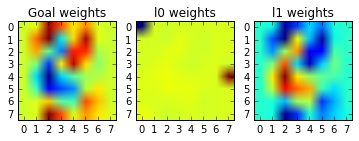

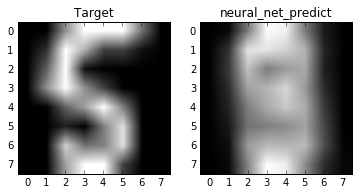

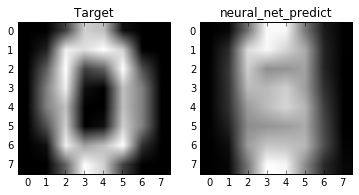

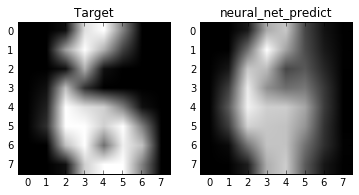

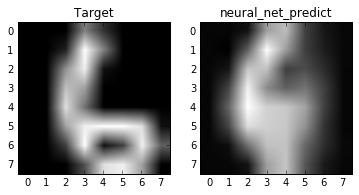

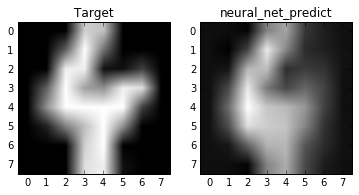

In [75]:
display_weights(optimized_params, hidden_unit=0, goal_weights=pca.components_[0])
visualise_predictions(optimized_params, num_predictions=5, X)

In [ ]:
# Save good weights in memory so we can use them later.
pickle_params("adam_4_9_good", optimized_params)

### Now to freeze the first set of weights...
To do this, I pass a boolean mask to the adam optimizer, indicating which parameters should be updated in the update step. The boolean mask is "False" for indices that correspond to a parameter (weight or bias) connecting to the first hidden unit, and "True" for indices that correspond to a parameter connecting to the second hidden unit.

In this specific example, I've pretty much hardcoded the boolean mask (see function unfrozen_first_hidden_unit_mask()).

In [77]:
# Note that flatten_func uses np.ravel() to flatten the weights matrix
# meaning the first (architecture[0] * num_hidden_units) elements in x 
# will be the weights of the first layer, and every num_hidden_units one
# (starting at index 0) needs to be frozen. Then the first bias needs to
# be frozen, and all others unfrozen. The change in dimensionality means
# that the next 1897 contiguous weights must be frozen, and all other 
# weights and biases can be unfrozen.

def unfrozen_first_hidden_unit_mask(architecture):
    """Returns a boolean mask indicating which weights are unfrozen.
    """
    num_hidden_units = architecture[1]
    
    # Freeze the weights entering the first hidden unit.
    mask = [True if i % num_hidden_units else False for i in range(architecture[0] * num_hidden_units)]
    # Freeze the first bias.
    mask.extend([False])  
    # Unfreeze all other biases.
    mask.extend([True for i in range(num_hidden_units - 1)])
    # Freeze the weights leaving the first hidden unit.
    mask.extend([False if i < architecture[2] else True for i in range(architecture[2] * num_hidden_units)])
    # Unfreeze the bias weights for the final layer.
    mask.extend([True for i in range(architecture[2])])
    
    return mask

In [76]:
# An autoencoder with a single hidden layer, but two hidden units.
architecture = [X.shape[1], 2, X.shape[1]]

weights = init_weights(architecture)

# Load the weights that the network learnt earlier and that we
# have verified match the first principal component closely.
optimized_params = read_pickle("adam_4_9_good.pickle")

# Insert the frozen weights into the correct rows / columns.
W0, b0 = weights[0]
optimized_W0, optimized_b0 = optimized_params[0]

W0[:,:-1] = optimized_W0
b0[:-1] = optimized_b0

W1, b1 = weights[1]
optimized_W1, _ = optimized_params[1]

W1[:-1,:] = optimized_W1

# We need to create a mask that tells our optimizer which weights
# to leave frozen, and which to update during training.
mask = unfrozen_first_hidden_unit_mask(architecture)

# Run the optimizer by passing the slice in.
second_order_params = adam(grad_objective, init_params=weights, step_size=step_size,
                       num_iters=(num_epochs * num_batches), callback=print_progress, unfrozen=mask)

(322,)
Training: [################################################# ] 99.9%

#### Check that our initial weights remained unfrozen...
(This visualisation should correspond exactly to the visualisation done above, after learning the single hidden unit network on its own)

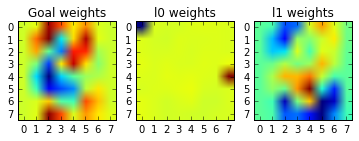

In [81]:
display_weights(second_order_params, hidden_unit=0, goal_weights=pca.components_[0])

#### And now compare the weights to / from the second hidden unit with the second principal component...

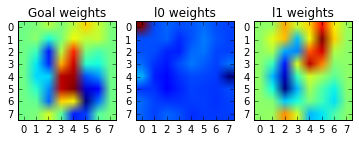

In [82]:
display_weights(second_order_params, hidden_unit=1, goal_weights=pca.components_[1])

### Training both hidden units at the same time...

In [ ]:
weights = init_weights(architecture)

optimized_params = adam(grad_objective, init_params=weights, step_size=step_size,
                       num_iters=(num_epochs * num_batches), callback=print_progress)

### C: the effect of nonlinearities
   1. now do the same (training all at once) with a hidden layer that involves a non-linearity (e.g. sigmoid, or relu).
   1. account for what you see.

In [80]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def nonlin_objective(params, iter):
    idx = batch_indices(iter)
    inputs = X[idx]
    predicted = neural_net_predict(params, inputs, nonlin=sigmoid)
    # Since we're training an autoencoder, the targets are 
    # equal to the inputs.
    return sse(predicted, target=inputs)

grad_nonlin_objective = grad(nonlin_objective)

In [ ]:
architecture = [X.shape[1], 2, X.shape[1]]

weights = init_weights(architecture)

optimized_nonlin_params = adam(grad_nonlin_objective, init_params=weights, step_size=step_size,
                       num_iters=(num_epochs * num_batches), callback=print_progress)